In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import *
from matplotlib import rc
from sklearn.cluster import KMeans

In [37]:
train_df = pd.read_csv('PD-data-train.csv', sep=';')
test_df = pd.read_csv('PD-data-test.csv', sep=';')
desc_df = pd.read_csv('PD-data-desc.csv', sep=';')

Анализ данных

In [4]:
train_df['default_12m'].value_counts(normalize = True)

0    0.935453
1    0.064547
Name: default_12m, dtype: float64

Имеется сильный дисбаланс классов, что необходимо учитывать при обучении модели

Параметр ul_strategic_flg не несет значимой информации, так как имеется только у 3 записей. Также, параметр ul_systematizing_flg всегда имеет значение 0.

In [5]:
train_df[(train_df['ul_strategic_flg'] == 1)]

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,...,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m
63,466,647086000.0,621092000.0,620692000.0,400000.0,0.0,25994000.0,-13174000.0,12820000.0,6390000.0,...,5,5,5,[1-100],387732000.0,1,0,1,0,0
24763,209428,647086000.0,621092000.0,620692000.0,400000.0,0.0,25994000.0,-13174000.0,12820000.0,6390000.0,...,5,5,5,[1-100],387732000.0,1,0,1,0,0
25080,212047,435862000.0,412123000.0,412123000.0,0.0,0.0,23739000.0,-5601000.0,18138000.0,4080000.0,...,1,1,1,> 500,2471090.0,998,0,1,0,0


Столбцы adr_actual_age, head_actual_age, cap_actual_age полность идентичны. 2 из 3 столбцов можно удалить

In [6]:
print((train_df['adr_actual_age'] == train_df['head_actual_age']).sum())
print((train_df['head_actual_age'] == train_df['cap_actual_age']).sum())

32395
32395


Также, удалим столбцы, которые имеют менее 30 уникальных значений

In [38]:
train_df.drop(['ul_systematizing_flg', 'ul_strategic_flg', 'ul_branch_cnt', 'ul_staff_range', 'head_actual_age' ,'cap_actual_age'], axis = 1, inplace = True)

In [8]:
train_df

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,...,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,ul_capital_sum,ul_founders_cnt,default_12m
0,7,52996000.0,48344000.0,48344000.0,0.0,0.0,4652000.0,-2608000.0,2044000.0,846000.0,...,0.0,11349000.0,4523000.0,0.0,198,136,3,50000.0,2,0
1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,256,135,12,10000.0,5,0
2,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,33,33,28,10000.0,2,0
3,22,32049000.0,29568000.0,29568000.0,0.0,0.0,2481000.0,-260000.0,2221000.0,302000.0,...,0.0,3652000.0,0.0,0.0,185,139,8,300000.0,1,0
4,23,16458000.0,14935000.0,14935000.0,0.0,0.0,1523000.0,-274000.0,1249000.0,538000.0,...,0.0,0.0,1279000.0,0.0,220,138,27,10000.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32390,274590,28264000.0,27911000.0,27911000.0,0.0,0.0,353000.0,-68000.0,285000.0,57000.0,...,0.0,0.0,13826000.0,0.0,71,71,5,10000.0,1,0
32391,274593,25017000.0,24381000.0,24381000.0,0.0,0.0,636000.0,0.0,636000.0,0.0,...,0.0,0.0,182000.0,0.0,168,141,25,600000.0,1,0
32392,274602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,11,11,11,10000.0,1,0
32393,274611,136162000.0,135088000.0,135088000.0,0.0,0.0,1074000.0,-719000.0,355000.0,267000.0,...,0.0,3676000.0,301000.0,0.0,70,70,13,11000.0,1,1


По описанию столбцов понятно, что некоторые столбцы являются уточнением к другим

In [9]:
desc_df

,field,desc_eng,desc_rus
0,ar_revenue,Sales revenue (at the end of the last year),Выручка от реализации (на конец последнего года)
1,ar_total_expenses,Total expenses for the last year,Общие расходы за последний год
2,ar_sale_cost,Cost of sales (at the end of the last year),Себестоимость продаж (на конец последнего года)
3,ar_selling_expenses,Selling expenses (at the end of the last year),Коммерческие расходы (на конец последнего года)
4,ar_management_expenses,Administrative expenses (at the end of the las...,Управленческие расходы (на конец последнего года)
5,ar_sale_profit,Profit from sales (at the end of the last year),Прибыль от реализации (на конец последнего года)
6,ar_balance_of_rvns_and_expns,Balance of income and expenses (at the end of ...,Баланс доходов и расходов (на конец последнего...
7,ar_profit_before_tax,Gross Profit (end of last year),Валовая прибыль (на конец последнего года)
8,ar_taxes,Current income tax (at the end of the last year),Текущий на налог на прибыль (на конец последне...
9,ar_other_profit_and_losses,Other income and expenses (at the end of the l...,Прочие доходы и расходы (на конец последнего г...


К примеру ar_total_expenses является суммой ar_sale_cost, ar_selling_expenses, ar_management_expenses (NAN значения не являются равными друг другу, поэтому они удаляются)

In [32]:
(train_df['ar_total_expenses'].dropna() == (train_df['ar_sale_cost'].dropna() + train_df['ar_selling_expenses'].dropna() + train_df['ar_management_expenses'].dropna())).sum()

17250

Оставив только основные столбцы, получим:

In [39]:
train_df = train_df[['ar_net_profit', 'ab_borrowed_capital', 'ab_immobilized_assets', 'ab_mobile_current_assets', 'ab_cash_and_securities','ab_own_capital', 'ab_losses','bus_age', 'ogrn_age','ul_founders_cnt', 'default_12m']]
train_df

,ar_net_profit,ab_borrowed_capital,ab_immobilized_assets,ab_mobile_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,bus_age,ogrn_age,ul_founders_cnt,default_12m
0,1198000.0,15872000.0,0.0,7240000.0,255000.0,1198000.0,663000.0,198,136,2,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256,135,5,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,33,2,0
3,1919000.0,3652000.0,0.0,4245000.0,25000.0,1919000.0,2219000.0,185,139,1,0
4,711000.0,1279000.0,0.0,8950000.0,492000.0,711000.0,12439000.0,220,138,2,0
...,...,...,...,...,...,...,...,...,...,...,...
32390,228000.0,13826000.0,0.0,10147000.0,639000.0,228000.0,-1597000.0,71,71,1,0
32391,636000.0,182000.0,3000.0,2977000.0,7000.0,636000.0,2805000.0,168,141,1,0
32392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,11,1,0
32393,88000.0,3977000.0,0.0,20357000.0,32000.0,88000.0,1412000.0,70,70,1,1


Заполним пропуски

Примерно половина строк имеют полностью пустые значения в 7 из 10 столбцов, поэтому просто убрать их не получится

In [40]:
train_df.isna().sum()

ar_net_profit               15145
ab_borrowed_capital         15145
ab_immobilized_assets       15145
ab_mobile_current_assets    15145
ab_cash_and_securities      15145
ab_losses                   15145
ab_own_capital              15145
bus_age                         0
ogrn_age                        0
ul_founders_cnt                 0
default_12m                     0
dtype: int64

Разобьем данные на кластеры по столбцам bus_age, ogrn_age, ul_founders_cnt и заполним пропуски медианным значнием (т.к. оно не чувствительно к выбросам)

In [41]:
from sklearn import preprocessing

col = ['bus_age', 'ogrn_age', 'ul_founders_cnt']

dataNorm = preprocessing.MinMaxScaler().fit_transform(train_df[col].values)
data_dist = pdist(dataNorm, 'euclidean')
#data_linkage = np.load('data_linkage_1.npy')

data_linkage = linkage(data_dist, method='average')
np.save('data_linkage_2',data_linkage)

nClust=8
clusters=fcluster(data_linkage, nClust, criterion='maxclust')
train_df['cluster']=clusters

train_df_not_na = train_df.copy()
for i in range(1,nClust+1,1):
    train_df_not_na.loc[train_df_not_na['cluster'] == i] = train_df_not_na.loc[train_df_not_na['cluster'] == i].fillna(train_df.loc[train_df['cluster'] == i].median())
train_df_not_na
train_df_not_na = train_df_not_na.fillna(0)

Проанализируем выбросы

C:\Users\HONOR\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ar_net_profit', ylabel='Density'>

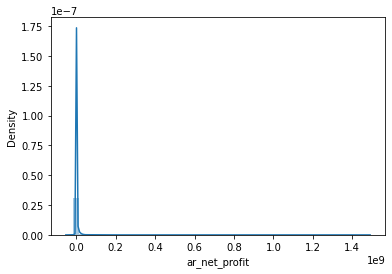

In [43]:
train_df = train_df_not_na.copy(deep = True)
sns.distplot(train_df['ar_net_profit'])

Похожая картина наблюдается во всех столбцах. Удалим выбросы

In [44]:
for column in train_df.drop(['default_12m'], axis =1):
    train_df = train_df[train_df[column] <= train_df[column].quantile(0.99)]
train_df

,ar_net_profit,ab_borrowed_capital,ab_immobilized_assets,ab_mobile_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,bus_age,ogrn_age,ul_founders_cnt,default_12m,cluster
0,1198000.0,15872000.0,0.0,7240000.0,255000.0,1198000.0,663000.0,198,136,2,0,4
1,1112500.0,9158500.0,0.0,15554000.0,319000.0,1042500.0,7627000.0,256,135,5,0,4
2,271000.0,4390500.0,0.0,4897000.0,171000.0,269000.0,489000.0,33,33,2,0,5
3,1919000.0,3652000.0,0.0,4245000.0,25000.0,1919000.0,2219000.0,185,139,1,0,4
4,711000.0,1279000.0,0.0,8950000.0,492000.0,711000.0,12439000.0,220,138,2,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32390,228000.0,13826000.0,0.0,10147000.0,639000.0,228000.0,-1597000.0,71,71,1,0,4
32391,636000.0,182000.0,3000.0,2977000.0,7000.0,636000.0,2805000.0,168,141,1,0,4
32392,271000.0,4390500.0,0.0,4897000.0,171000.0,269000.0,489000.0,11,11,1,0,5
32393,88000.0,3977000.0,0.0,20357000.0,32000.0,88000.0,1412000.0,70,70,1,1,4


In [45]:
df = train_df.drop(['cluster'], axis = 1).copy(deep = True)
df

,ar_net_profit,ab_borrowed_capital,ab_immobilized_assets,ab_mobile_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,bus_age,ogrn_age,ul_founders_cnt,default_12m
0,1198000.0,15872000.0,0.0,7240000.0,255000.0,1198000.0,663000.0,198,136,2,0
1,1112500.0,9158500.0,0.0,15554000.0,319000.0,1042500.0,7627000.0,256,135,5,0
2,271000.0,4390500.0,0.0,4897000.0,171000.0,269000.0,489000.0,33,33,2,0
3,1919000.0,3652000.0,0.0,4245000.0,25000.0,1919000.0,2219000.0,185,139,1,0
4,711000.0,1279000.0,0.0,8950000.0,492000.0,711000.0,12439000.0,220,138,2,0
...,...,...,...,...,...,...,...,...,...,...,...
32390,228000.0,13826000.0,0.0,10147000.0,639000.0,228000.0,-1597000.0,71,71,1,0
32391,636000.0,182000.0,3000.0,2977000.0,7000.0,636000.0,2805000.0,168,141,1,0
32392,271000.0,4390500.0,0.0,4897000.0,171000.0,269000.0,489000.0,11,11,1,0
32393,88000.0,3977000.0,0.0,20357000.0,32000.0,88000.0,1412000.0,70,70,1,1


Данные имеют большой разброс в значениях. Используем модуль StandardScaler

In [47]:
from sklearn.preprocessing import StandardScaler

df_y = df['default_12m']

scaler = StandardScaler()
scaler.fit(df.drop(['default_12m'], axis = 1))
df_x = scaler.transform(df.drop(['default_12m'], axis = 1))


Для решения проблемы дисбаланса классов используем модуль RandomOverSampler. Такой подход показал лучшие результаты, чем задание весов классов классификации

In [48]:
from imblearn.over_sampling import RandomOverSampler
OverS = RandomOverSampler(random_state=52)
X_Over, Y_Over = OverS.fit_resample(df_x, df_y)

X = X_Over
y = Y_Over

X.shape

(54594, 10)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42, shuffle=True)

In [55]:
model = keras.Sequential([
    #keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation = 'sigmoid'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(16, activation = 'sigmoid'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(20, activation = 'sigmoid'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(35, activation = 'sigmoid'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation = 'sigmoid'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(5, activation = 'sigmoid'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(2, activation = 'softmax')
])

model.compile(loss="binary_crossentropy", 
    optimizer="adam",
    metrics=['accuracy'])


#class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)
#class_weights = dict(enumerate(class_weights))
#print(class_weights)
y_cat = keras.utils.to_categorical(y_train,2)
y_test_cat = keras.utils.to_categorical(y_test,2)
model.fit(X_train, y_cat, epochs = 20,  validation_data = (X_test, y_test_cat))

Epoch 1/20
1280/1280 [==============================] - 10s 5ms/step - loss: 0.6562 - accuracy: 0.6166 - val_loss: 0.6552 - val_accuracy: 0.6195
Epoch 2/20
1280/1280 [==============================] - 6s 5ms/step - loss: 0.6504 - accuracy: 0.6228 - val_loss: 0.6492 - val_accuracy: 0.6204
Epoch 3/20
1280/1280 [==============================] - 6s 5ms/step - loss: 0.6494 - accuracy: 0.6227 - val_loss: 0.6477 - val_accuracy: 0.6268
Epoch 4/20
1280/1280 [==============================] - 6s 5ms/step - loss: 0.6475 - accuracy: 0.6232 - val_loss: 0.6451 - val_accuracy: 0.6254
Epoch 5/20
1280/1280 [==============================] - 6s 5ms/step - loss: 0.6467 - accuracy: 0.6241 - val_loss: 0.6420 - val_accuracy: 0.6259
Epoch 6/20
1280/1280 [==============================] - 7s 5ms/step - loss: 0.6453 - accuracy: 0.6276 - val_loss: 0.6480 - val_accuracy: 0.6225
Epoch 7/20
1280/1280 [==============================] - 6s 4ms/step - loss: 0.6439 - accuracy: 0.6251 - val_loss: 0.6404 - val_accuracy

Подготовим данные тестовой выборки, удалив лишние столбцы по аналогии с тренировочными данными и заполиним пропуски.

In [56]:
test_df.drop(['ul_systematizing_flg', 'ul_strategic_flg', 'ul_branch_cnt', 'ul_staff_range', 'head_actual_age' ,'cap_actual_age'], axis = 1, inplace = True)

In [57]:
col2 = ['bus_age', 'ogrn_age', 'ul_founders_cnt']

In [59]:
train_dataNorm = preprocessing.StandardScaler().fit_transform(test_df[col2].values)
train_data_dist = pdist(train_dataNorm, 'euclidean')
train_data_linkage = linkage(train_data_dist, method='average')

In [60]:
train_nClust=4
clusters=fcluster(train_data_linkage, train_nClust, criterion='maxclust')
test_df['cluster']=clusters

In [61]:
test_df_not_na = test_df.copy()
for i in range(1,train_nClust+1,1):
    test_df_not_na.loc[test_df_not_na['cluster'] == i] = test_df_not_na.loc[test_df_not_na['cluster'] == i].fillna(test_df.loc[test_df['cluster'] == i].median())

test_df_not_na_ = test_df_not_na.drop(['cluster', 'record_id'], axis = 1).fillna(0)
#test_df_not_na_

In [62]:
df_test = test_df_not_na_.copy(deep = True)
#df_test = df_test[['ar_net_profit', 'ab_borrowed_capital', 'ab_immobilized_assets', 'ab_mobile_current_assets', 'ab_cash_and_securities', 'ab_losses', 'ab_own_capital', 'bus_age', 'ogrn_age', 'adr_actual_age','ul_founders_cnt']]
df_test

,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,...,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,ul_capital_sum,ul_founders_cnt
0,39103000.0,38913000.0,38913000.0,0.0,0.0,190000.0,141000.0,331000.0,284000.0,0.0,...,6130000.0,0.0,3000000.0,3130000.0,0.0,156,135,3,100000.0,1
1,17958000.0,15200000.0,15200000.0,0.0,0.0,1093000.0,-36000.0,502000.0,65000.0,0.0,...,4784000.0,0.0,80000.0,2158000.0,0.0,216,138,5,100000.0,1
2,54174000.0,50929000.0,50929000.0,0.0,0.0,3245000.0,-1278000.0,1967000.0,500000.0,0.0,...,3906000.0,0.0,0.0,3906000.0,0.0,244,138,20,250000.0,2
3,1904000.0,1679000.0,1679000.0,0.0,0.0,225000.0,-88000.0,137000.0,0.0,0.0,...,540000.0,0.0,500000.0,40000.0,0.0,272,139,9,10000.0,2
4,225584000.0,210685000.0,210685000.0,0.0,0.0,14899000.0,-12715000.0,2184000.0,445000.0,0.0,...,47017000.0,0.0,16215000.0,30802000.0,0.0,254,139,3,1700598.0,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,21287000.0,18838000.0,16227000.0,2611000.0,0.0,2449000.0,-123000.0,2326000.0,483000.0,0.0,...,6714000.0,1216000.0,0.0,5498000.0,0.0,47,47,32,10000.0,1
196,17958000.0,15200000.0,15200000.0,0.0,0.0,1093000.0,-36000.0,502000.0,65000.0,0.0,...,4784000.0,0.0,80000.0,2158000.0,0.0,283,140,6,0.0,1
197,17958000.0,15200000.0,15200000.0,0.0,0.0,1093000.0,-36000.0,502000.0,65000.0,0.0,...,4784000.0,0.0,80000.0,2158000.0,0.0,22,22,7,20000.0,1
198,759009000.0,726682000.0,551903000.0,18323000.0,156456000.0,32327000.0,-23281000.0,9046000.0,431000.0,0.0,...,313378000.0,145888000.0,99847000.0,67643000.0,0.0,140,140,31,100000.0,2


In [63]:
df_test = df_test[['ar_net_profit', 'ab_borrowed_capital', 'ab_immobilized_assets', 'ab_mobile_current_assets', 'ab_cash_and_securities','ab_losses','ab_own_capital', 'bus_age', 'ogrn_age','ul_founders_cnt']]

In [64]:
scaler.fit(df_test)
df_test1 = scaler.transform(df_test)
df_test1 = pd.DataFrame(data = df_test1, columns = df_test.columns)

In [65]:
df_test1

,ar_net_profit,ab_borrowed_capital,ab_immobilized_assets,ab_mobile_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,bus_age,ogrn_age,ul_founders_cnt
0,-0.288757,-0.191221,-0.168407,-0.287196,0.215408,-0.286985,-0.266301,0.888305,1.507577,-0.124893
1,-0.226163,-0.220989,-0.168407,-0.258323,-0.249630,-0.224196,-0.247554,1.634728,1.572822,-0.124893
2,-0.006587,-0.240407,-0.168407,-0.236143,-0.211767,-0.003937,0.009874,1.983059,1.572822,-0.094207
3,-0.270873,-0.314848,-0.168407,-0.292358,-0.407879,-0.269045,-0.045977,2.331389,1.594570,-0.094207
4,0.047462,0.713024,-0.168407,1.114666,0.486275,0.050281,0.281948,2.107462,1.594570,2.422072
...,...,...,...,...,...,...,...,...,...,...
195,0.068128,-0.178306,-0.159732,-0.230274,2.018279,0.071609,-0.107831,-0.467696,-0.406254,-0.124893
196,-0.226163,-0.220989,-0.168407,-0.258323,-0.249630,-0.224196,-0.247554,2.468233,1.616318,-0.124893
197,-0.226163,-0.220989,-0.168407,-0.258323,-0.249630,-0.224196,-0.247554,-0.778706,-0.949956,-0.124893
198,1.413800,6.603789,9.726565,5.042475,1.028982,1.420873,5.806763,0.689259,1.616318,-0.094207


Подготовим итоговый csv файл

In [66]:
answ_df = test_df[['record_id']]

answ_df['id'] = answ_df['record_id']
answ_df.drop('record_id',axis=1, inplace=True)

#df_test = df_test/df_test.max()

C:\Users\HONOR\AppData\Local\Temp\ipykernel_2952\3811603239.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answ_df['id'] = answ_df['record_id']
C:\Users\HONOR\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [67]:
arr = model.predict(df_test1.values)
answ_arr = []
for i in range(len(arr)):
    answ_arr.append(np.argmax(arr[i]))

    
answ_df['predict'] = answ_arr
answ_df['predict'].value_counts()

C:\Users\HONOR\AppData\Local\Temp\ipykernel_2952\1564224219.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answ_df['predict'] = answ_arr


0    144
1     56
Name: predict, dtype: int64

In [68]:
answ_df.to_csv('PD-submit-0.csv',index=False, sep = ';')